# COMPREHENSIVE GUIDE TO HYPERPARAMETER TUNING
[Vikum Wijesinghe](https://www.linkedin.com/in/vikumwijesinghe/) - September 2019

Other Kernels: https://www.kaggle.com/vikumsw/kernels

---

# Problem Description

### There is an <font color="NAVY">ANGRY BABY</font>. What <font color="NAVY">FLAVOR</font> of <font color="NAVY">ICE CREAM</font> would you think is the best to make the baby pleased?

|||
|:-:|:-:|
|![](https://media.giphy.com/media/26gsnlYjswkyY3ENq/giphy.gif)|![](https://media.giphy.com/media/HuAvEGGh9o8rC/giphy.gif)|

### Analogy:
* Angry Baby   -> Problem
* Ice Cream    -> Choosen ML Algorithm to solve the problem
* Flavors      -> Configurations/Properties of the ML Algorithm



### How are you going to solve the problem?
1. Choose the most popular flavor :-> <font color="GRAY">Using your Machine Learning algorithm with default hyperparameters, You would most likely end up with a suboptimal model.</font>
2. Choose the flavor baby likes the most :-> <font color="GRAY">Tuning your models Hyperparameters to get the most skillful model.</font>


Keep Reading to find out how to choose the flavor baby likes the most

# Table Of Contents

1. [What are hyperparameters?]()
1. [Some examples of hyperparameters]()
1. [Why they are important?]()
1. [How to tune hyperparamters?]()
1. [generate a regression problem for the exercise]()
1. [Hyperparameter Tuning Using Grid Search]()

#### Libray Imports

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import Image

## What are hyperparameters?

Let's create a Random Forest Regressor model for demonstration,

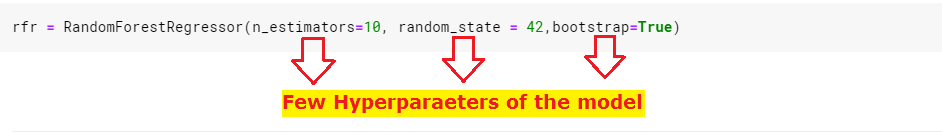

In [2]:
Image("../input/notebookimages/hy.PNG")

These parameters express configurations of the model such as its structure or learning rates. They are called hyperparameters.
These values cannot be estimated from data. So hyperparameters are usually set before training. Think of it like there exist different flavors of the same machine learning algorithm.

![](https://media.giphy.com/media/QmKtZGQn4cNi6EC15Y/giphy.gif)

## Some examples of hyperparameters :
* Number of leaves or depth of a tree
* Learning rate
* Number of hidden layers in a deep neural network
* Number of clusters in a k-means clustering

## Why are they important?.

In addition to choosing the best suited Machine Learning model for a particular problem, selecting the best flavour of the selected model also decides the performance.

## How to tune hyperparamters?
There are several ways of choosing a set of optimal hyperparameters for a learning algorithm.
* Grid search
* Manual search 
* Random search
* Bayesian Optimization and More..

I will stick to grid search in this discussion, links to study others are provided in the bottom of the notebook. 

## Data for the exercise

For this exercise let's generate a random regression problem using sklearn.datasets.make_regression.

[Want to know more on make_regression?. have a look..](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)

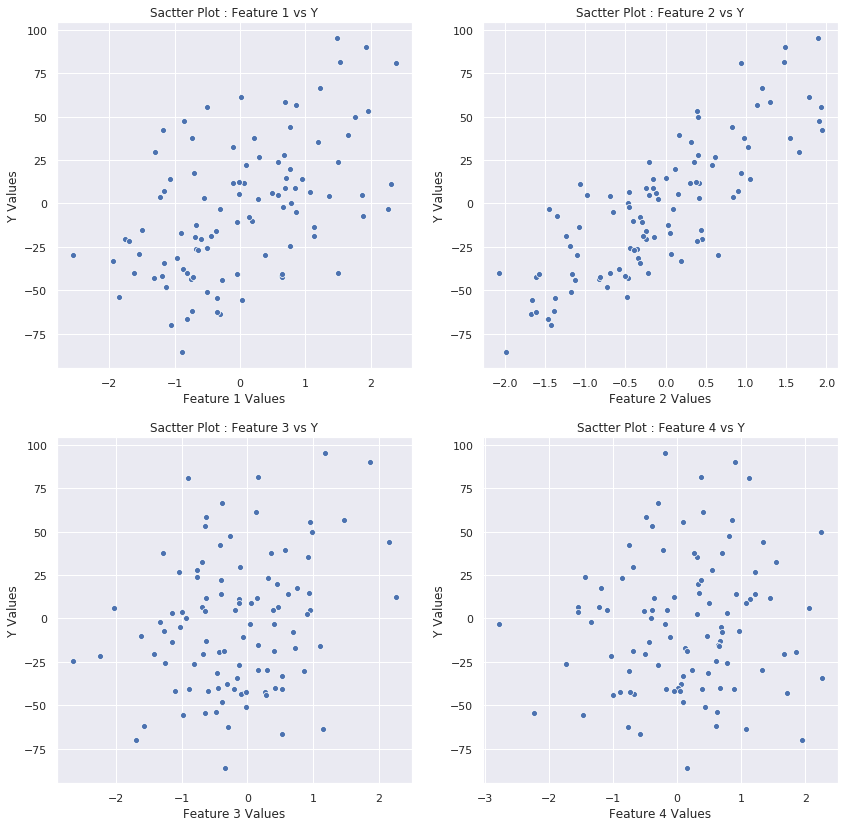

In [3]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)


f,ax=plt.subplots(2,2,figsize=(14,14))

sns.scatterplot(x=X[:,0], y=y, ax=ax[0,0])
ax[0,0].set_xlabel('Feature 1 Values')
ax[0,0].set_ylabel('Y Values')
ax[0,0].set_title('Sactter Plot : Feature 1 vs Y')

sns.scatterplot(x=X[:,1], y=y,ax=ax[0,1])
ax[0,1].set_xlabel('Feature 2 Values')
ax[0,1].set_ylabel('Y Values')
ax[0,1].set_title('Sactter Plot : Feature 2 vs Y')

sns.scatterplot(x=X[:,2], y=y,ax=ax[1,0])
ax[1,0].set_xlabel('Feature 3 Values')
ax[1,0].set_ylabel('Y Values')
ax[1,0].set_title('Sactter Plot : Feature 3 vs Y')

sns.scatterplot(x=X[:,3], y=y,ax=ax[1,1])
ax[1,1].set_xlabel('Feature 4 Values')
ax[1,1].set_ylabel('Y Values')
ax[1,1].set_title('Sactter Plot : Feature 4 vs Y')

plt.show()

## Hyperparameter tuning using grid search

> The traditional way of performing hyperparameter optimization has been grid search, or a parameter sweep, which is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.
([Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search))

Now Data is ready for training... First we need a regressor ... lets choose RandomForestRegressor... and see default values of hyperparamters

In [4]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
print('Parameters currently in use:\n')
pprint(rfr.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Thats default parameters. Our target is to find the best set of hyperparameters from a subset taken from hyperparameter space.
For this we need to,
* Define the parameter grid : -> Subset from the hyperparameter space to search.
* Make a scorer : -> This scorer will be use to choose the best performing model.

Then we create the GridSearch model using sklearn.model_selection.GridSearchCV and proceed to trainig. Let's see how its done.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# define the search space.
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 75, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [200,500,1000,2000]}

# make scorer
RMSE = make_scorer(mean_squared_error, greater_is_better=False)

# Configure the GridSearch model
model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=4, scoring=RMSE, verbose=2)
# n_jobs=-1 : Means configured to use parallelism. use n_jobs=1 if use wish not to.

# Training
model.fit(X, y)

print('Random forest regression...')
print('Best Params:', model.best_params_)
print('Best CV Score:', -model.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   26.2s finished


Random forest regression...
Best Params: {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
Best CV Score: 109.08632508026415


Explanation : 
We have scored random forest regressor for following hyperparameter settings.

| bootstrap | max_depth  | max_features  | min_samples_leaf  |  min_samples_split | n_estimators  |
|:-:|:-:|:-:|:-:|:-:|---|
| True  | 50 |  'auto' |  2 | 5  |  200 |
| True  | 50 |  'auto' |  2 | 5  |  200 |
| True  | 50 |  'auto' |  2 | 5  |  200 |
| True  | 50 |  'auto' |  2 | 5  | 500 |
| True  | 75 |  'auto' |  2 | 5  |  500 |
| True  | 75 |  'auto' |  2 | 5  |  500 |
| True  | 75 |  'auto' |  2 | 5  |  1000 |
| True  | 75 |  'auto' |  2 | 5  |  1000 |
| True  | 100 |  'auto' |  2 | 5  |  1000 |
| True  | 100 |  'auto' |  2 | 5  |  2000 |
| True  | 100 |  'auto' |  2 | 5  |  2000 |
| True  | 100 |  'auto' |  2 | 5  |  2000 |


Parameter set that have given us the best fitting is : {'bootstrap': True, 'max_depth': 75, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000} with a score of 109.74999198367817. Number of CV folds used was 4.

### Next??
Now since we know the best parameter configuration we can use this for training and prediction afterwards.
Its time to come up with the best random forest regressor inside our hyperparameter search space for this particular problem.

In [6]:
rfr_best = RandomForestRegressor(bootstrap= True, max_depth=75, max_features='auto',min_samples_leaf=2, min_samples_split=5, n_estimators = 2000)

### Let's see how it goes!. Time to calm the Baby...

![](https://media.giphy.com/media/AGGz7y0rCYxdS/giphy.gif)

### Oh How Cute! Bravo!!!. Given the best solution!

## Learn More
* [What are hyperparameters in machine learning?](https://www.quora.com/What-are-hyperparameters-in-machine-learning)
* [What is the Difference Between a Parameter and a Hyperparameter?](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)
* [Hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

## Please upvote if you found it useful and joyful!